In [1]:
import cv2, operator
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

Using TensorFlow backend.


In [2]:
#process the image after loading the image from disk
def preprocess_img(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (700, 700)) 
    gray = cv2.GaussianBlur(gray, (5,5), 0)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    return thresh

In [3]:
#get corners of sudoku grid

def find_corners_of_largest_polygon(img):
    """Finds the 4 extreme corners of the largest contour in the image."""
    contours = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Find contours
    polygon = max(contours[1], key=cv2.contourArea)  # Sort by area, descending
    
    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))



    return [polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]
# print(find_corners_of_largest_polygon(processed))



In [4]:
#crop and warp
def distance_between(p1, p2):
    """Returns the scalar distance between two points"""
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return np.sqrt((a ** 2) + (b ** 2))
def crop_and_warp(img, crop_rect):
    """Crops and warps a rectangular section from an image into a square of similar size."""

    # Rectangle described by top left, top right, bottom right and bottom left points
    top_left, top_right, bottom_right, bottom_left = crop_rect[0], crop_rect[1], crop_rect[2], crop_rect[3]

    # Explicitly set the data type to float32 or `getPerspectiveTransform` will throw an error
    src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

    # Get the longest side in the rectangle
    side = max([
        distance_between(bottom_right, top_right),
        distance_between(top_left, bottom_left),
        distance_between(bottom_right, bottom_left),
        distance_between(top_left, top_right)
    ])

    # Describe a square with side of the calculated length, this is the new perspective we want to warp to
    dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')

    # Gets the transformation matrix for skewing the image to fit a square by comparing the 4 before and after points
    m = cv2.getPerspectiveTransform(src, dst)

    # Performs the transformation on the original image
    return cv2.warpPerspective(img, m, (int(side), int(side)))

In [5]:
#get squares on the grid
def getMeanBrightness(cropped_img, row_loc):
    return np.mean(cropped_img[row_loc,:])

def getGridSquares(cropped_img,THRESHOLD_1):
    width, height = cropped_img.shape
    row_distance = height/9
    column_distance = width/9
    rows_line = []
    for i in range(10):
        line1 = min(int(i*row_distance),cropped_img.shape[0]-1-THRESHOLD_1)
        corrected_line = line1
        maxi_val = np.mean(cropped_img[line1,:])
        for j in range(max(line1-THRESHOLD_1,0),line1+THRESHOLD_1):
            mn_val = np.mean(cropped_img[j,:])
            if(mn_val>maxi_val):
                corrected_line = j
                maxi_val = mn_val
                
        rows_line.append(corrected_line)
    cols_line = []
    for i in range(10):
        line1 = min(int(i*column_distance),cropped_img.shape[1]-1-THRESHOLD_1)
        corrected_line = line1
        maxi_val = np.mean(cropped_img[:,line1])
        for j in range(max(line1-THRESHOLD_1,0),line1+THRESHOLD_1):
            mn_val = np.mean(cropped_img[:,j])
            if(mn_val>maxi_val):
                corrected_line = j
                maxi_val = mn_val
        cols_line.append(corrected_line)
    squares = []
    for i in range(1,10):
        for j in range(1,10):
            sq = ((cols_line[j-1],rows_line[i-1]),(cols_line[j],rows_line[i]))
            squares.append(sq)
    return squares

In [6]:
#get numbered cells
def get_filled_cells(image,cells, crop_factor, threshold):
    cell_pos = []
    selected = []
    for i, cell in enumerate(cells):
        tmp_thresh = int((cell[1][1] - cell[0][1])*crop_factor)
        newIm = cropped[cell[0][1]+tmp_thresh:cell[1][1]-tmp_thresh,cell[0][0]+tmp_thresh:cell[1][0]-tmp_thresh]
        newIm = processCrop(newIm,150)
        if(np.mean(newIm)>threshold):
            selected.append(cell)
            cell_pos.append(i)
    return (selected, cell_pos)

In [7]:
#processing individual cells to remove gridline artifact
def processCrop(image,threshold):
    #horizontals
    last_line = image[image.shape[0]-1,:]
    min_mean = np.mean(last_line)
    b = 1
    while(min_mean>threshold):
        b+=1
        last_line = image[image.shape[0]-b,:]
        min_mean = np.mean(last_line)
    top_line = image[0,:]
    min_mean = np.mean(top_line)
    t = 0
    while(min_mean>threshold):
        t+=1
        top_line = image[t,:]
        min_mean = np.mean(top_line)
        
    left_line = image[:,0]
    min_mean = np.mean(left_line)
    l = 0
    while(min_mean>threshold):
        l+=1
        left_line = image[:,l]
        min_mean = np.mean(left_line)
    right_line = image[:,image.shape[1]-1]
    min_mean = np.mean(right_line)
    r = 1
    while(min_mean>threshold):
        r+=1
        right_line = image[:,image.shape[1]-r]
        min_mean = np.mean(right_line)
    newImg = image[t:image.shape[0]-b,l:image.shape[1]-r]
    return newImg

# idx = 0
# crop_factor = 0.1
# cell = pre_filled_cells[idx]
# image = cropped.copy()
# tmp_thresh = int((cell[1][1] - cell[0][1])*crop_factor)        
# newIm = image[cell[0][1]+tmp_thresh:cell[1][1]-tmp_thresh,cell[0][0]+tmp_thresh:cell[1][0]-tmp_thresh]
# newIm = processCrop(newIm,150)

# plt.imshow(newIm,cmap="gray")

# y_axis = []
# x_axis = []
# for i in range(newIm.shape[0]):
    
#     y_axis.append(np.mean(newIm[i,:]))
#     x_axis.append(i)

# plt.plot(x_axis,y_axis)

In [8]:
#Main script - creates the cropped image objekt
MORPH_FILTER = True
file_name = 'Sudoku1.jpg'

img = cv2.imread(file_name)
processed = preprocess_img(img)
corners = find_corners_of_largest_polygon(processed)
cropped = crop_and_warp(processed.copy(), corners)


if(MORPH_FILTER):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
    cropped = cv2.morphologyEx(cropped, cv2.MORPH_OPEN, kernel)

squares = getGridSquares(cropped,12)

image = cv2.cvtColor(cropped.copy(),cv2.COLOR_GRAY2RGB)

pre_filled_cells, cell_pos = get_filled_cells(cropped,squares,0.25,26)
print(len(pre_filled_cells))
for cell in squares:
    image = cv2.rectangle(image.copy(),cell[0],cell[1],(255,0,0),3)
for cell in pre_filled_cells:
    image = cv2.rectangle(image.copy(),cell[0],cell[1],(0,255,0),2)
cv2.imwrite("grid.jpg",image)


29


True

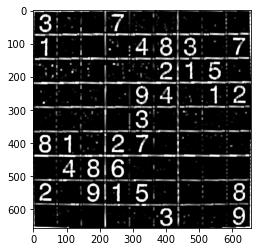

In [9]:
#View the cropped objekt here

def getProcessedCell(image, cell,crop_factor,threshold):
    tmp_thresh = int((cell[1][1] - cell[0][1])*crop_factor)
    newIm = image[cell[0][1]+tmp_thresh:cell[1][1]-tmp_thresh,cell[0][0]+tmp_thresh:cell[1][0]-tmp_thresh]
    newIm = processCrop(newIm,threshold)
    return newIm

# newIm = getProcessedCell(cropped,pre_filled_cells[0],0.1,150)
# plt.imshow(newIm, cmap="gray")
plt.imshow(cropped,cmap="gray")

In [12]:
#Predictions are done here

def predict_array(selected,image,crop_factor):
#     model1 = load_model("model3.h5")
    model = load_model("model.h5")
    data = []
    for cell in selected:
        tmp_thresh = int((cell[1][1] - cell[0][1])*crop_factor)
        
        newIm = image[cell[0][1]+tmp_thresh:cell[1][1]-tmp_thresh,cell[0][0]+tmp_thresh:cell[1][0]-tmp_thresh]
        newIm = processCrop(newIm,150)
        resized_im = cv2.resize(newIm, (28, 28),  
               interpolation = cv2.INTER_NEAREST)
        data.append((resized_im/255).reshape((28,28,1)))
    data = np.array(data)
#     predictions1 = model1.predict(data)
    predictions = model.predict(np.array(data))
#     net_predictions = (predictions1+predictions2)/2
    
    return (predictions, data)

        
    
result, data = predict_array(pre_filled_cells,cropped,0.10)


In [21]:
result[27]

array([9.6758015e-09, 8.6154133e-01, 1.3845687e-01, 1.7112584e-13,
       2.3288843e-10, 1.0374819e-12, 9.3375479e-07, 9.2113083e-07,
       2.4670657e-10], dtype=float32)

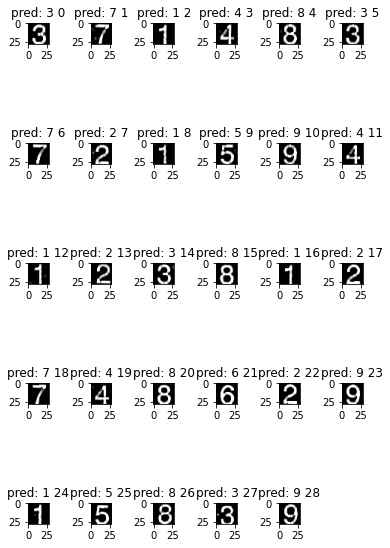

In [13]:
#display predictions here for checking
import matplotlib.pyplot as plt


for i in range(len(pre_filled_cells)):
    plt.subplot(5,6,i+1)
    plt.title("pred: "+str(np.argmax(result[i])+1)+" "+str(i))
    plt.imshow(data[i].reshape((28,28)),cmap="gray")
    
plt.subplots_adjust(hspace=1, wspace=2,top=2)
plt.show()
    

    

In [14]:
#digitized array is created here
digitized = [
        [0 for _ in range(9)] for _ in range(9)
    ]
for pos, res in zip(cell_pos,result):
    y_cord = pos//9
    x_cord = pos-y_cord*9
    digitized[y_cord][x_cord] = np.argmax(res)+1

In [16]:
digitized

[[3, 0, 0, 7, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 4, 8, 3, 0, 7],
 [0, 0, 0, 0, 0, 2, 1, 5, 0],
 [0, 0, 0, 0, 9, 4, 0, 1, 2],
 [0, 0, 0, 0, 3, 0, 0, 0, 0],
 [8, 1, 0, 2, 7, 0, 0, 0, 0],
 [0, 4, 8, 6, 0, 0, 0, 0, 0],
 [2, 0, 9, 1, 5, 0, 0, 0, 8],
 [0, 0, 0, 0, 0, 2, 0, 0, 9]]

In [15]:
#Solution is computed here
def checkValidity(arr, i, j, val):
    baseI = (i//3)*3
    baseJ = (j//3)*3
    for _i in range(baseI,baseI+3):
        for _j in range(baseJ,baseJ+3):
            if(arr[_i][_j]==val):
                return False
    for _i in range(9):
        if(arr[_i][j]==val):
            return False
    for _j in range(9):
        if(arr[i][_j]==val):
            return False
    return True

def solve(arr, i,j):
    
    if(i>8):
        i=0
        j+=1
    if(j==9):
        return True
    if(arr[i][j]!=0):
        res = solve(arr,i+1,j)
        if(res):
            return True
        else:
            return False
    for _i in range(1,10):
        res = checkValidity(arr,i,j,_i)
        res2 = False
        if(res):
            arr[i][j] = _i
            res2 = solve(arr,i+1,j)
            if(res2):
                return True
            arr[i][j] = 0
    return False
cpy = digitized.copy()      
print(solve(cpy,0,0))
cpy
    

False


[[3, 0, 0, 7, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 4, 8, 3, 0, 7],
 [0, 0, 0, 0, 0, 2, 1, 5, 0],
 [0, 0, 0, 0, 9, 4, 0, 1, 2],
 [0, 0, 0, 0, 3, 0, 0, 0, 0],
 [8, 1, 0, 2, 7, 0, 0, 0, 0],
 [0, 4, 8, 6, 0, 0, 0, 0, 0],
 [2, 0, 9, 1, 5, 0, 0, 0, 8],
 [0, 0, 0, 0, 0, 2, 0, 0, 9]]

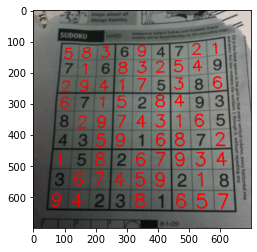

In [31]:
#Overlay to be created here - cpy is the solved array
B_channel = np.zeros(cropped.shape)
G_channel = np.zeros(cropped.shape)
R_channel = np.zeros(cropped.shape)
img_BGRA = cv2.merge((B_channel, G_channel, R_channel))
_i_ = -1
for cell in squares:
    _i_+=1
    if(_i_ in cell_pos):
        continue
    y_cord = _i_//9
    x_cord = _i_-y_cord*9
    img_BGRA = cv2.putText(img_BGRA, str(cpy[y_cord][x_cord]), (cell[0][0]+10,cell[0][1]+55), cv2.FONT_HERSHEY_SIMPLEX ,  
                   2, (255,0,0,1), 3, cv2.LINE_AA) 

    # Performs the transformation on the original image
top_left, top_right, bottom_right, bottom_left = corners[0], corners[1], corners[2], corners[3]
dst = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

side = img_BGRA.shape[0]
src = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')
m = cv2.getPerspectiveTransform(src, dst)

new_image_overlay = cv2.warpPerspective(img_BGRA, m, (700,700))
base_img = cv2.resize((img.copy()),(700,700))
fnl_img = np.zeros((700,700,3),dtype="uint8")
for _i_ in range(700):
    for _j_ in range(700):
        if(new_image_overlay[_i_][_j_][0]>150):
            fnl_img[_i_][_j_][0] = new_image_overlay[_i_][_j_][0]
        else:
            fnl_img[_i_][_j_][0] = base_img[_i_][_j_][0]
            fnl_img[_i_][_j_][1] = base_img[_i_][_j_][1]
            fnl_img[_i_][_j_][2] = base_img[_i_][_j_][2]
plt.imshow(fnl_img)

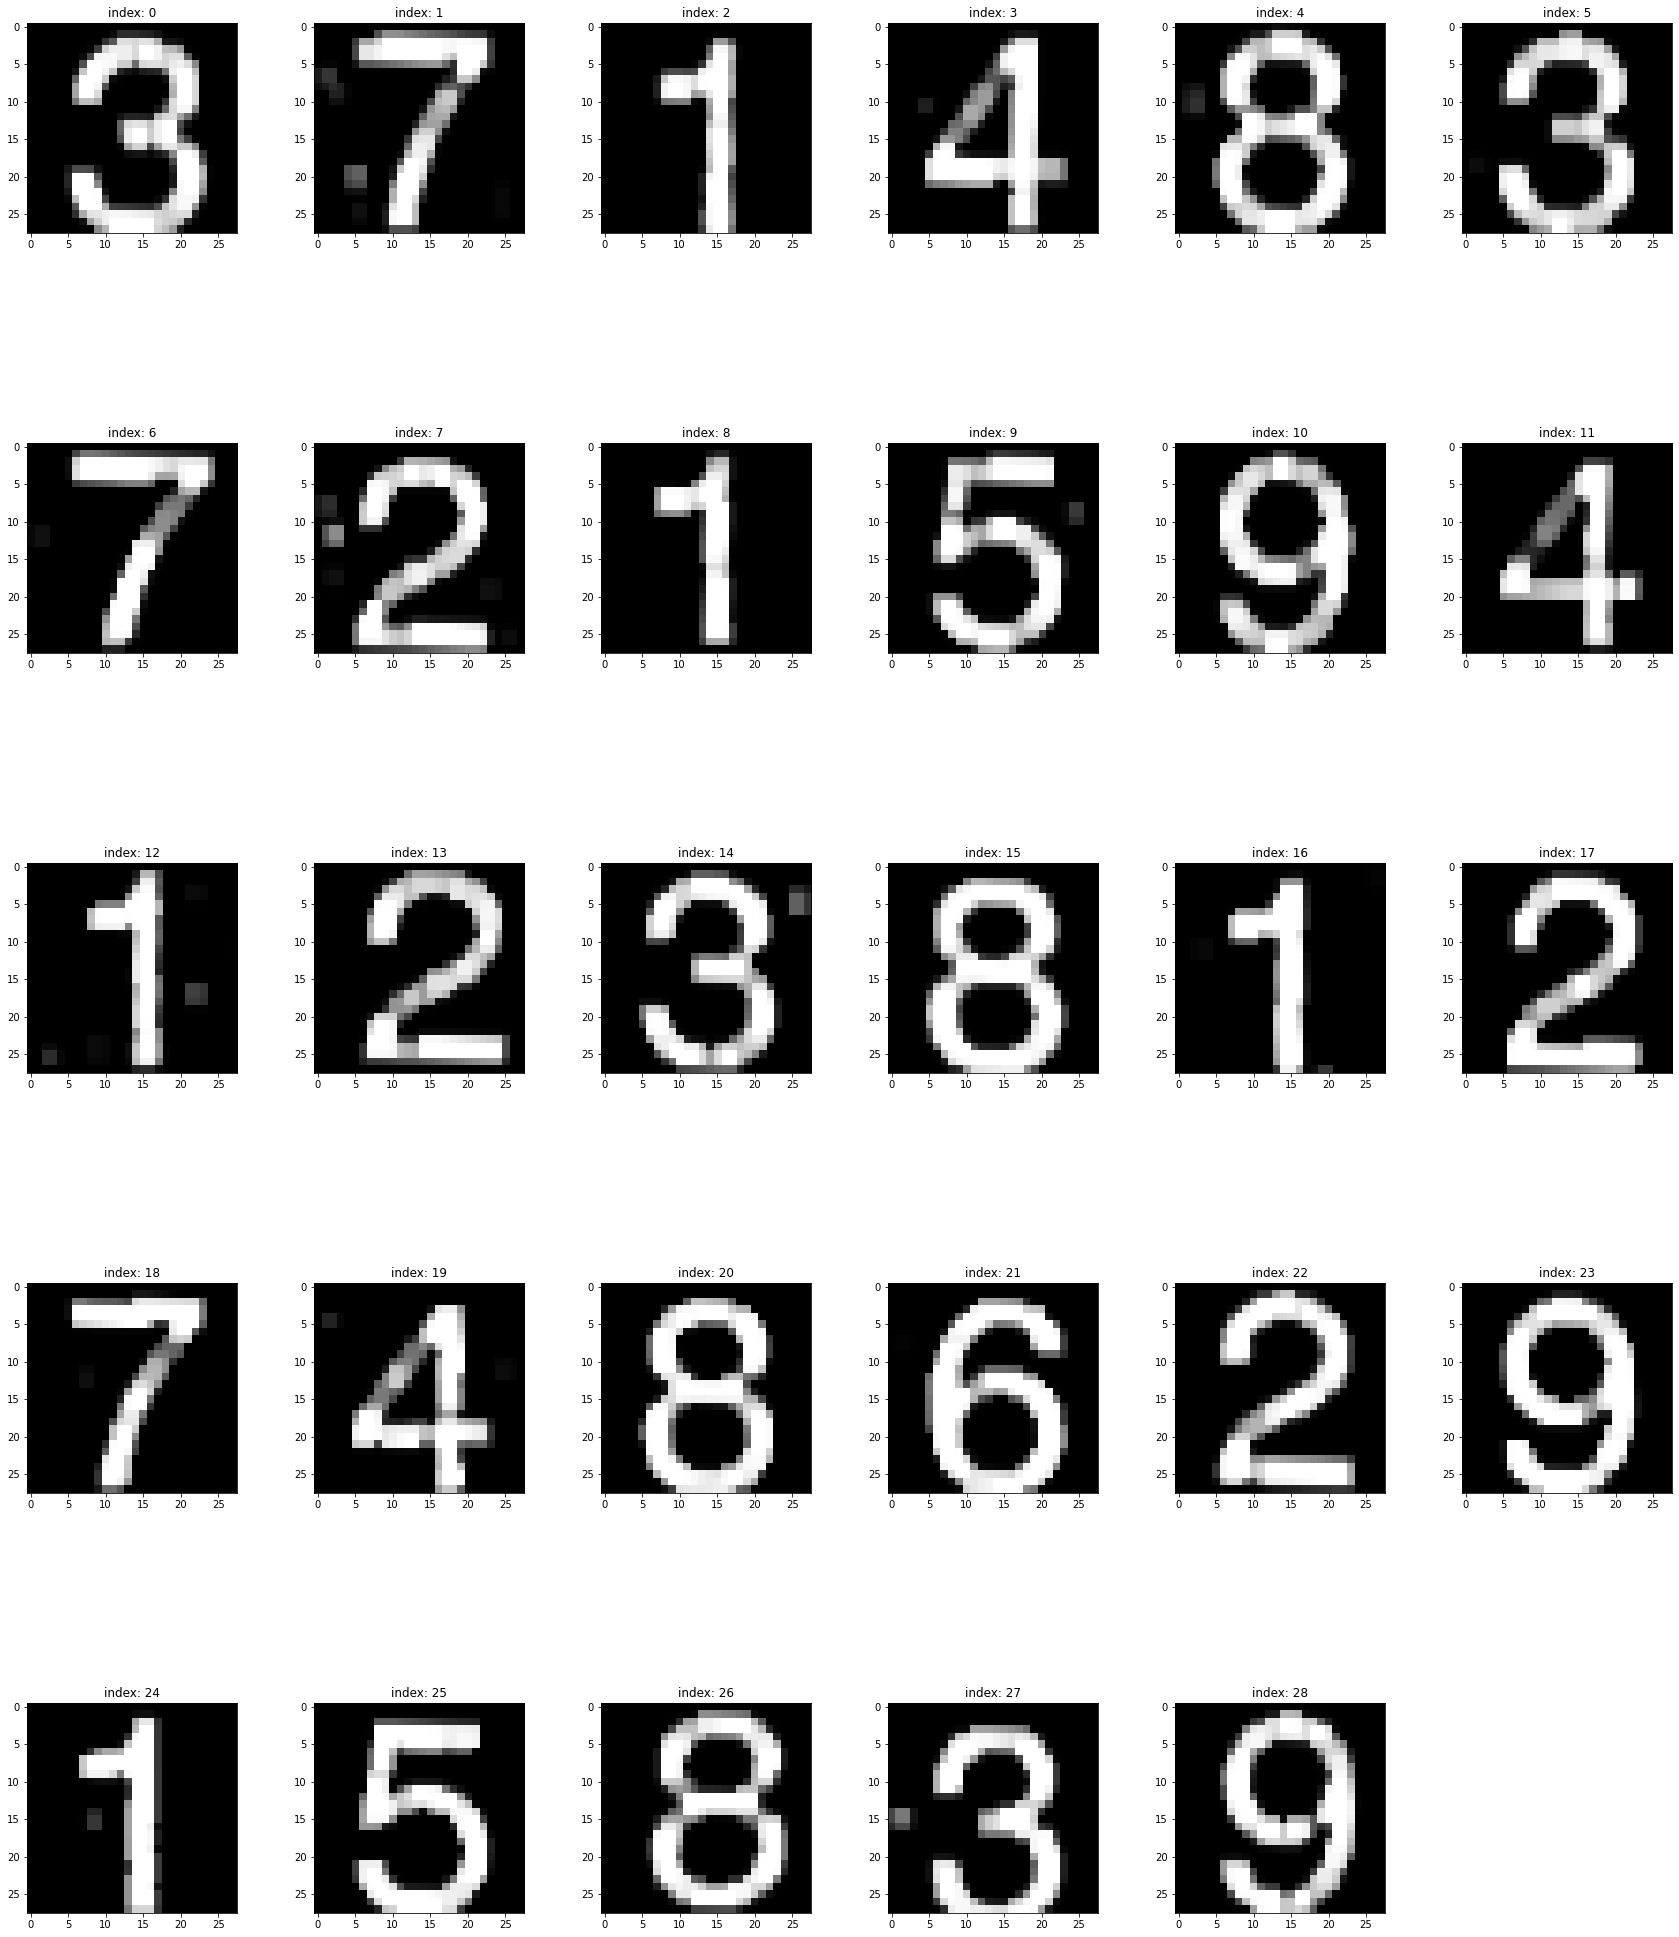

In [23]:
#Used to create dataset for model training
import matplotlib.pyplot as plt
plt.figure(figsize = (30,30))
crop_factor = 0.10
labels = [3,7,1,4,8,3,7,2,1,5,9,4,1,2,3,8,1,2,7,4,8,6,2,9,1,5,8,3,9]
for i, cell in enumerate(pre_filled_cells):
    tmp_thresh = int((cell[1][1] - cell[0][1])*crop_factor)
    newIm = cropped[cell[0][1]+tmp_thresh:cell[1][1]-tmp_thresh,cell[0][0]+tmp_thresh:cell[1][0]-tmp_thresh]
    newIm = processCrop(newIm,100)
    res_im = cv2.resize(newIm,(28,28))
    plt.subplot(5,6,i+1)
    plt.title("index: "+str(i))
    plt.imshow(res_im,cmap="gray")
    cv2.imwrite("dataset\sample3_"+str(labels[i])+"_"+str(i)+".png",res_im)
    
plt.subplots_adjust(hspace=1, wspace=0.2, top=1)
plt.show()